##Set Up

In [1]:
import pandas as pd
import numpy as np
import json
import os, pickle
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [4]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  11532      0 --:--:-- --:--:-- --:--:-- 11613
OK
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unsele

In [5]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723212644,"nanos":652513088},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723212644,"nanos":652747691},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [6]:
#check mounting
os.listdir(local_path)

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

##Sample Image Per Class

In [7]:
#check number of images (train): 6254
imageFilenames = pd.DataFrame(os.listdir(f"{local_path}/train_data_preprocessed"), columns=['image'])
numImage = len(imageFilenames)
print("Number of Images: ", numImage)
imageFilenames.tail(5)

Number of Images:  6254


,image
6249,N36_100EK113_05160644.JPG
6250,N36_100EK113_05160645.JPG
6251,N36_100EK113_05240655.JPG
6252,N36_100EK113_05260667.JPG
6253,N36_100EK113_05260668.JPG


In [8]:
#load the labels from file in drive
df_train_label = pickle.load(open(local_path+'/feature_matrices/train_label.pkl', 'rb'))
df_train_label.head()

,label,group
image,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2
N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2
N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2
N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2
N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2


In [9]:
#join for labels
df = imageFilenames.merge(df_train_label, on='image', how='left')
df.head(5)

,image,label,group
0,A01_02260289.JPG,Peccary,Peccary-3984d0e5-7160-11ec-8e68-5cf3706028c2
1,A01_02260291.JPG,Peccary,Peccary-3984d0e5-7160-11ec-8e68-5cf3706028c2
2,A01_02260292.JPG,Peccary,Peccary-3984d0e5-7160-11ec-8e68-5cf3706028c2
3,A01_02260293.JPG,Peccary,Peccary-3984d0e5-7160-11ec-8e68-5cf3706028c2
4,A01_02260294.JPG,Peccary,Peccary-3984d0e5-7160-11ec-8e68-5cf3706028c2


#Viz on Samples

In [ ]:
#select image sample per class

species_list = list(df['label'].unique())

sample_filenames = []

for item in species_list:
  sample_filenames.append(df[df['label']==item].sample()['image'].values[0])

In [10]:
# species_list = list(df['label'].unique())

# sample_filenames = ['M04_102EK113_02110753.JPG',
#                     'N16_06160659.JPG',
#                     'A02_100EK113_01250150.JPG',
#                     'A04_101EK113_06290989.JPG',
#                     'N19_100EK113_03210495.JPG',
#                     'N04_101EK113_06190889.JPG']

##Feature Viz on Sample

###Processed

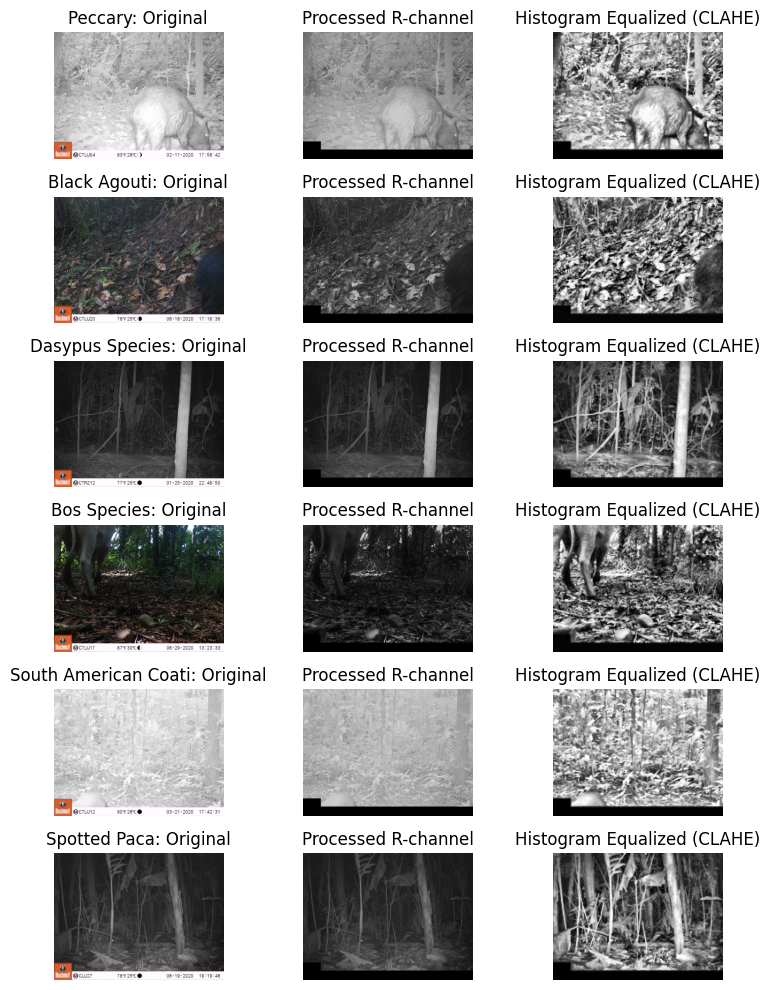

In [15]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=3, figsize=(8, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  img_ori = plt.imread(f"{local_path}/raw-data/train_data/{sample_filenames[i]}")
  img_red = plt.imread(f"{local_path}/train_data_preprocessed/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.1, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)

  #visualize
  axs[i, 0].imshow(img_ori)
  axs[i, 0].set_title(species_list[i]+": Original")
  axs[i, 0].axis("off")

  axs[i, 1].imshow(img_gray, cmap='gray')
  axs[i, 1].set_title("Processed R-channel")
  axs[i, 1].axis("off")

  axs[i, 2].imshow(img_cl, cmap='gray')
  axs[i, 2].set_title("Histogram Equalized (CLAHE)")
  axs[i, 2].axis("off")

plt.show()

###HOG

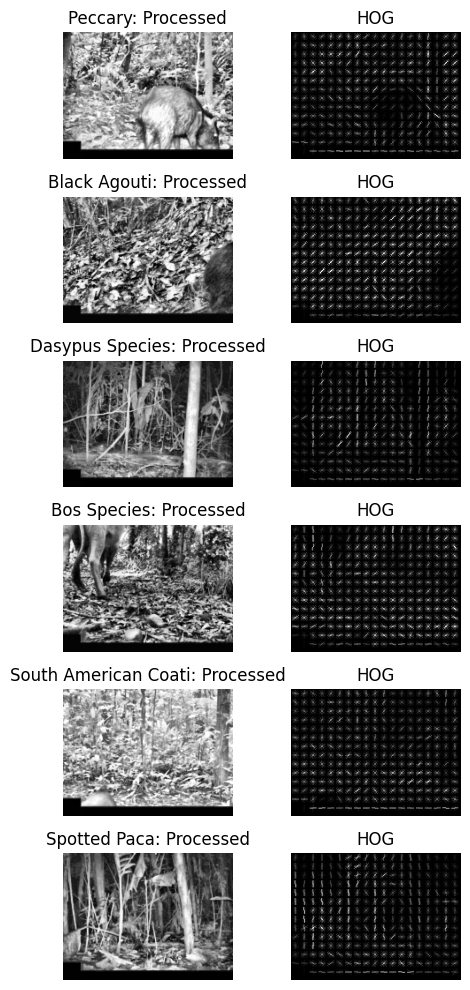

In [18]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=2, figsize=(5, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  img_ori = plt.imread(f"{local_path}/raw-data/train_data/{sample_filenames[i]}")
  img_red = plt.imread(f"{local_path}/train_data_preprocessed/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.1, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)

  #HOG
  features, h = hog(img_cl, orientations=8, pixels_per_cell=(10, 10), visualize=True)

  #visualize
  axs[i, 0].imshow(img_cl, cmap='gray')
  axs[i, 0].set_title(species_list[i]+": Processed")
  axs[i, 0].axis("off")

  axs[i, 1].imshow(h, cmap='gray', vmin=0, vmax=65)
  axs[i, 1].set_title("HOG")
  axs[i, 1].axis("off")

plt.show()

###Edges (Sobel, Canny)

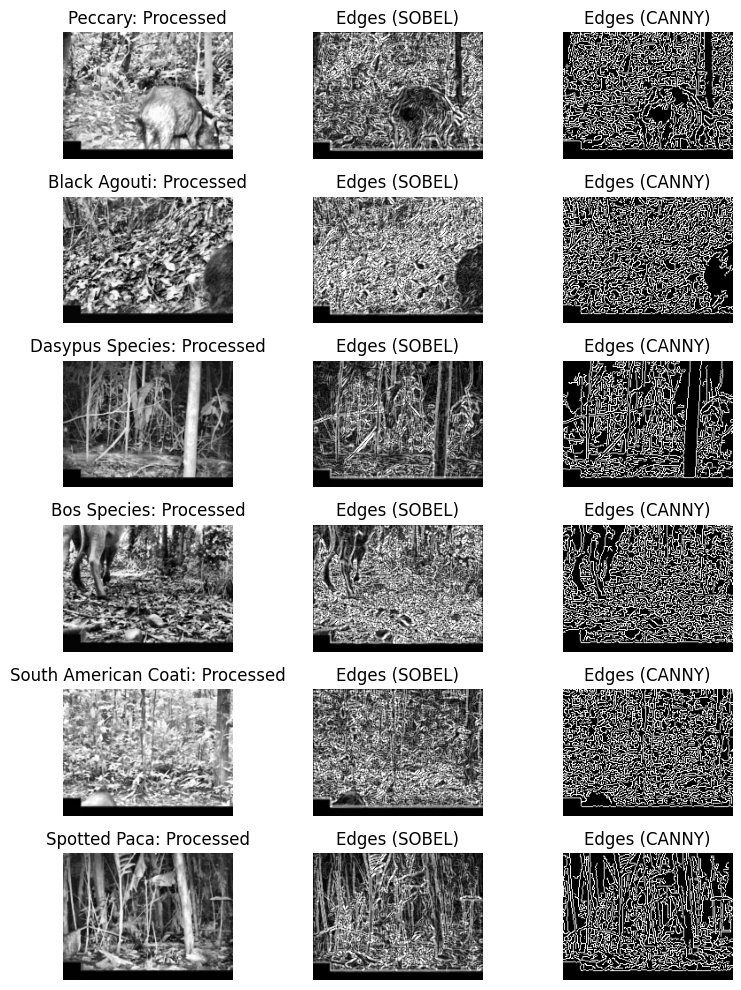

In [19]:
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=3, figsize=(8, 10), tight_layout=True)

for i in range(len(sample_filenames)):

  img_ori = plt.imread(f"{local_path}/raw-data/train_data/{sample_filenames[i]}")
  img_red = plt.imread(f"{local_path}/train_data_preprocessed/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  img_resized = rescale(img_gray, 0.1, anti_aliasing=True)
  img_resized = (img_resized * 255 / img_resized.max()).astype(np.uint8)

  #histogram equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img_cl = clahe.apply(img_resized)

  #edge detection with sobel
  grad_x = cv2.Sobel(img_cl, cv2.CV_64F, 1, 0)
  grad_y = cv2.Sobel(img_cl, cv2.CV_64F, 0, 1)
  abs_grad_x = cv2.convertScaleAbs(grad_x)
  abs_grad_y = cv2.convertScaleAbs(grad_y)
  grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

  #edge detection with canny
  grad_canny = cv2.Canny(img_cl, 85, 255)

  #visualize
  axs[i, 0].imshow(img_cl, cmap='gray')
  axs[i, 0].set_title(species_list[i]+": Processed")
  axs[i, 0].axis("off")

  axs[i, 1].imshow(grad, cmap='gray')
  axs[i, 1].set_title("Edges (SOBEL)")
  axs[i, 1].axis("off")

  axs[i, 2].imshow(grad_canny, cmap='gray')
  axs[i, 2].set_title("Edges (CANNY)")
  axs[i, 2].axis("off")

plt.show()